<a href="https://colab.research.google.com/github/institutohumai/cursos-python/blob/master/MachineLearning/2_RegresionLinealMultiple/RegresionLinealMultiple.ipynb">> <img src='https://colab.research.google.com/assets/colab-badge.svg' /> </a>

# Regresión Lineal Múltiple

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Indicamos que los tipos de datos float se muestren con 2 decimales
pd.options.display.float_format = '{:.2f}'.format

## Dataset propiedades

Continuamos en la misma consultora estadística de la clase pasada  y ahora nos contrata una empresa que se dedica a comprar y remodelar propiedades para luego venderlas. En esta oportunidad quiere que realicemos algunos modelos para predecir los precios de las propiedades y además poder entender como influyen en el precio determinadas variables para entender que modificaciones pueden llegar a aumentar el precio.

El dataset consiste en los anuncios de ventas de Properati de propiedades en la Ciudad de Buenos Aires durante el primer semestre de 2021. Nuestra variable a predecir es el precio de la propiedad en dolares y las posibles variables predictoras son:

*  Superficie Total: superficie total de la propiedad en metros cuadrados
*  Superficie Cubierta: superficie cubierta de la propiedad en metros cuadrados
*  Ambientes/Cuartos: cantidad de ambientes/cuartos (excluyendo baños)
*  Baños: cantidad de baños
*  Tipo de propiedad: si la propiedad es una casa, departamento o propiedad horizontal (PH)
*  Latitud
*  Longitud
*  Barrio: barrio donde se encuentra la propiedad (l3)

Datos provistos por <a href='https://www.properati.com.ar'>Properati</a>

<u>Exploremos un poco los datos:</u>


In [2]:
# Lectura del dataset
df = pd.read_csv('https://datasets-humai.s3.amazonaws.com/datasets/properati_caba_2021.csv')

In [3]:
# Definimos la semilla
SEMILLA = 1992

## 1. Analisis exploratorios

In [4]:
# Observamos los primeros registros del dataframe
df.head()

,id,lat,lon,l3,rooms,bathrooms,surface_total,surface_covered,price,property_type
0,5dmWZ4uqAU4kpJw0AEc/Hw==,-34.62,-58.40,San Cristobal,7.00,6.00,534.00,384.00,470000.00,Casa
1,kFa6ndbLuJ2k2zfzI1fY3A==,-34.56,-58.46,Belgrano,1.00,1.00,25.00,25.00,60000.00,Departamento
2,S0fct9jgpfmuqmOaPntC/Q==,-34.62,-58.38,Monserrat,1.00,1.00,40.00,40.00,82500.00,Departamento
3,sduUfHxdOh9PuRwJruEcyA==,-34.62,-58.38,San Telmo,1.00,1.00,40.00,40.00,82500.00,Departamento
4,Tl1ebIQJyPOXV2XJMEImQg==,-34.62,-58.38,Constitución,1.00,1.00,40.00,40.00,82500.00,Departamento


In [5]:
# Observamos la matriz de correlación entre las variables numéricas
df.corr()

<ipython-input-5-52de5c4302be>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,lat,lon,rooms,bathrooms,surface_total,surface_covered,price
lat,1.00,-0.14,-0.01,0.10,0.02,0.04,0.15
lon,-0.14,1.00,0.05,0.08,0.05,0.09,0.18
rooms,-0.01,0.05,1.00,0.62,0.74,0.75,0.49
bathrooms,0.10,0.08,0.62,1.00,0.74,0.75,0.67
surface_total,0.02,0.05,0.74,0.74,1.00,0.97,0.72
surface_covered,0.04,0.09,0.75,0.75,0.97,1.00,0.76
price,0.15,0.18,0.49,0.67,0.72,0.76,1.00


Observamos que las variables de **superficie** presentan una correlación positiva alta con el precio y una correlación muy fuerte entre sí.

La variable de **baños** presenta una correlación positiva bastante alta seguida por la variable de **ambientes**.

Por último, las variables de latitud y longitud presentan un correlación positiva baja con el precio.

Observemos los gráficos de dispersión de algunas de estas variables con el precio

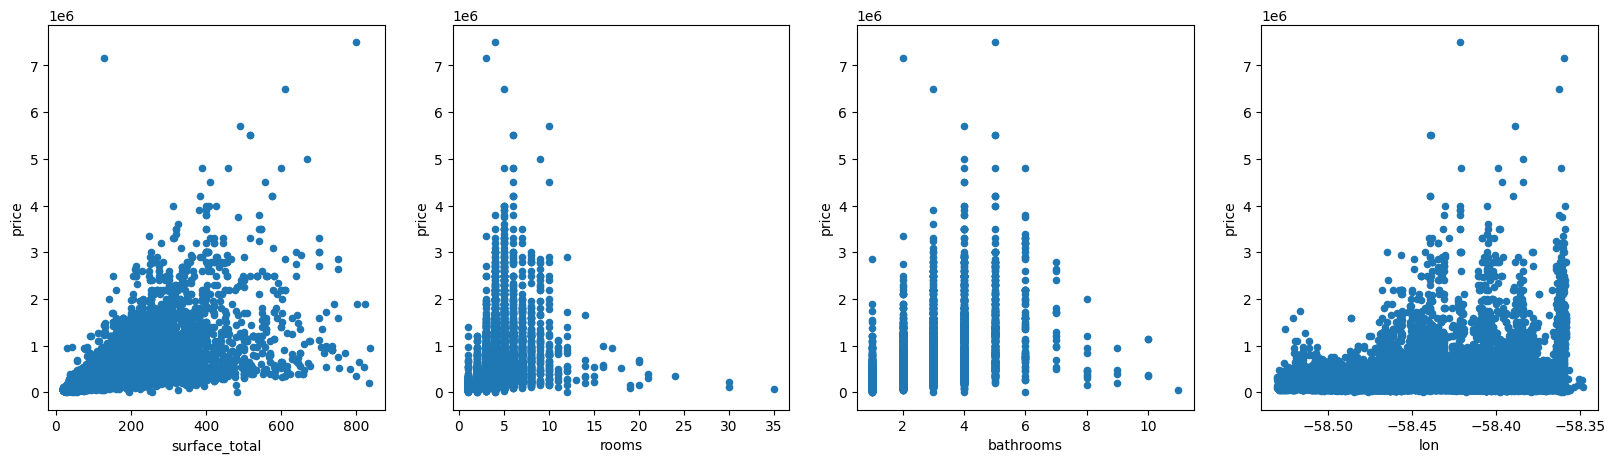

In [6]:
# Graficamos algunas de estas relaciones con el precio
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
df.plot.scatter(x='surface_total', y='price', ax=ax1)
df.plot.scatter(x='rooms', y='price', ax=ax2)
df.plot.scatter(x='bathrooms', y='price', ax=ax3)
df.plot.scatter(x='lon', y='price', ax=ax4);

Observamos que de estas 4 variables la que parece tener una relación aproximadamente lineal con el precio es la **superficie total**.

Por otro lado, vemos que existen algunas observaciones que son **outliers** (valores atípicos) en las variables. Por ejemplo: hay propiedades con 30 y 35 ambientes y algunas 10 baños o más

Ahora que ya conocemos un poco sobre los datos podemos proceder a diseñar e implementar algunos modelos para estimar el precio de las propiedades


## 2. Modelos: Estimación e interpretación

Vamos a desarrollar modelos de regresión lineal múltiple con la siguiente especificación:

$E(Y|X_1, X_2, ..., X_p) = \beta_0 + \beta_1 \cdot X_1 + \beta_2  \cdot X_2 + ... + \beta_p \cdot X_p $

En esta sección desarrollaremos distintos modelos con las variables numéricas que vimos previamente y observaremos los coeficientes estimados y su interpretación

### 2.1 Preparación de los datos

Como se vio en la clase previa, para evaluar los modelos que diseñemos es necesario separar a los datos en:

*   Conjunto de **entrenamiento**: datos con los cuales vamos a entrenar los modelos
*   Conjunto de **evaluación**: datos con los cuales vamos a evaluar la performance del modelo

Esto lo vamos a realizar con la función [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html). Le pasamos como argumentos el set de datos de variables predictoras, la serie de la variable a predecir y el porcentaje de datos que deseamos que forme nuestro set de evaluación.



In [7]:
# Separamos al dataset en X (variables predictoras) e y (variable a predecir)
X = df[['lat', 'lon', 'rooms', 'bathrooms', 'surface_total', 'surface_covered', 'property_type']]
y = df['price']

In [8]:
from sklearn.model_selection import train_test_split
# Realizamos el split de X e y en los sets de entrenamiento (train) y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=SEMILLA)

In [9]:
print(f"El dataset de entrenamiento cuenta con {len(X_train)} observaciones")
print(f"El dataset de evaluación cuenta con {len(X_test)} observaciones")

El dataset de entrenamiento cuenta con 32124 observaciones
El dataset de evaluación cuenta con 8032 observaciones


### 2.2 Modelo Superficie y Baños

Por lo que vimos en nuestro análisis de datos las variables de **superficie total** y **baños** presentan un correlación positiva bastante alta con el precio. Entonces, comencemos con un modelo que incluya ambas variables como predictoras:

$E(precio|.) = \beta_0 + \beta_1 \cdot superficieTotal + \beta_2 \cdot baños$

In [10]:
# Definimos las variables exogenas (predictores)
variables_exogenas = ['surface_total', 'bathrooms']

In [11]:
# Construimos la matriz de X
X_train_modelo_sup_baños = X_train[variables_exogenas]
X_train_modelo_sup_baños.head()

,surface_total,bathrooms
36377,63.00,1.00
8124,42.00,1.00
34075,160.00,1.00
28781,126.00,2.00
4876,32.00,1.00


In [12]:
# Importamos el modelo lineal
from sklearn.linear_model import LinearRegression

In [13]:
# Definimos una instancia del modelo lineal con scikit learn
modelo_lineal_sup_baños = LinearRegression(fit_intercept=True)

In [14]:
# Realizamos el proceso de estimación
modelo_lineal_sup_baños.fit(X_train_modelo_sup_baños, y_train)

LinearRegression()

In [15]:
# Accedemos a los coeficientes estimados
modelo_lineal_sup_baños.coef_

array([  2069.77563582, 113359.64561445])

In [16]:
# Accedemos al intercepto
modelo_lineal_sup_baños.intercept_

-107213.65573087399

In [17]:
# Creamos variables para guardar los coeficientes estimados
coeficientes = modelo_lineal_sup_baños.coef_
intercepto = modelo_lineal_sup_baños.intercept_
beta_1, beta_2 = coeficientes[0], coeficientes[1]

In [18]:
print(f"El intercepto es {intercepto:.2f}")
print(f"El coeficiente estimado para Beta 1 es {beta_1:.2f}")
print(f"El coeficiente estimado para Beta 2 es {beta_2:.2f}")

El intercepto es -107213.66
El coeficiente estimado para Beta 1 es 2069.78
El coeficiente estimado para Beta 2 es 113359.65


In [19]:
# Definimos una función para obtener los coeficientes en un dataframe
def obtener_coeficientes(modelo, lista_variables):
  '''Crea un dataframe con los coeficientes estimados de un modelo'''
  # Creo la lista de nombres de variables
  lista_variables = ['intercepto'] + lista_variables
  # Intercepto
  intercepto = modelo.intercept_
  # Lista coeficientes excepto el intercepto
  coeficientes = list(modelo.coef_)
  # Lista completa coeficientes
  lista_coeficientes = [intercepto] + coeficientes
  return pd.DataFrame({"variable": lista_variables, "coeficiente": lista_coeficientes})

In [20]:
# Obtenemos nuestro dataframe
coeficientes_modelo_sup_baños = obtener_coeficientes(modelo_lineal_sup_baños, variables_exogenas)
coeficientes_modelo_sup_baños

,variable,coeficiente
0,intercepto,-107213.66
1,surface_total,2069.78
2,bathrooms,113359.65


¿Cómo interpretamos estos coeficientes?

$\hat{\beta_0} = -107213.75$

El valor esperado/promedio/predicho de una propiedad sin superficie ni baños es de -107213.65 dólares

$\hat{\beta_1} = 2069.77$

El valor esperado/promedio/predicho de una propiedad aumenta en 2069.77 dólares frente a un aumento de 1 metro cuadrado de la superficie total dada la cantidad de baños

$\hat{\beta_2} = 113359.64$

El valor esperado/promedio/predicho de una propiedad aumenta en 113359.64 dólares frente a un aumento de 1 baño dada la superficie total


### 2.2 Modelo Superficie y Cuartos

También vimos en nuestro análisis de datos que la variable **cuartos** presentan un correlación positiva con el precio. Entonces, realicemos un modelo con los cuartos y la superficie total como predictoras:

$E(precio|.) = \beta_0 + \beta_1 \cdot superficieTotal + \beta_2 \cdot cuartos$

In [21]:
# Definimos las variables exogenas (predictores)
variables_exogenas = ['surface_total', 'rooms']

# Construimos la matriz de X
X_train_modelo_sup_cuartos = X_train[variables_exogenas]

# Definimos una instancia del modelo lineal con scikit learn
modelo_lineal_sup_cuartos = LinearRegression(fit_intercept=True)

# Realizamos el proceso de estimación
modelo_lineal_sup_cuartos.fit(X_train_modelo_sup_cuartos, y_train)

# Obtenemos los coeficientes en el dataframe
coeficientes_modelo_sup_cuartos = obtener_coeficientes(modelo_lineal_sup_cuartos, variables_exogenas)
coeficientes_modelo_sup_cuartos

,variable,coeficiente
0,intercepto,11793.04
1,surface_total,3290.52
2,rooms,-21992.68


¿Qué sucedió con los coeficientes estimados del modelo?

Lo que nos puede llamar la atención en modelo es que el coeficiente de la variable **ambientes** es negativo.

Alguien podría decirnos que la interpretación de este coeficiente es extraña y contraintuitiva si decimos que: el coeficiente $\hat{\beta_2} = -21992$ indica que frente al aumento de un ambiente el precio esperado de la propiedad cae en 21992 dólares.

#### Sin embargo, esto es incorrecto ¿Por qué?

Porque la interpretación del coeficiente estimado en el modelo de regresión lineal múltiple se realiza **dadas las otras variables constantes**

#### Entonces ¿Cúal es la interpretación correcta?

La interpretación correcta de $\hat{\beta_2} = 21992$ es:

El valor esperado de una propiedad cae en 21992 dólares frente al aumento de 1 ambiente dada la superficie total.

Esto quiere decir que si para una propiedad que tiene una superficie dada se crea un ambiente nuevo (dividir la superficie en más cuartos) se espera que su valor caiga en aproximadamente 22000 dolares  

## 3. Modelo con variables categóricas

En esta sección vamos a incorporar la variable categórica del **tipo de propiedad** en nuestros modelos.

Primero veamos como se relaciona esta variable con el precio de la propiedad



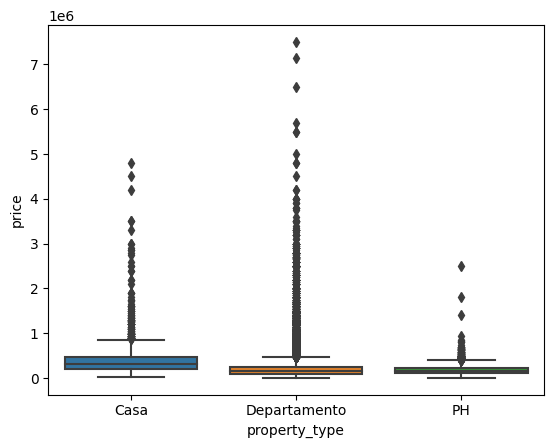

In [22]:
# Boxplot del precio por tipo de propiedad
sns.boxplot(x='property_type', y='price', data=df);

Se observa que existen múltiples **outliers** que dificultan la comparación entre los distintos tipos de propiedad. Las casas y departamentos se caracterizan por tener más outliers que los PH.

Acotemos el gráfico a propiedades con precios menores a 1 millón de pesos

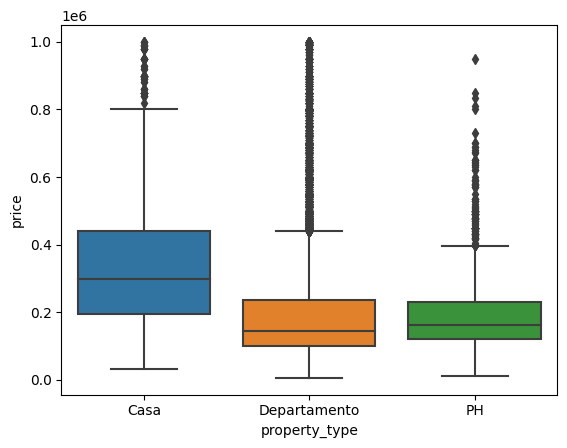

In [23]:
# Boxplot del precio por tipo de propiedad
sns.boxplot(x='property_type', y='price', data=df.query("price<=1000000"));

Ahora podemos observar que los departamentos y PH tienen una mediana similar mientras que las casas tiene una mediana de precio más elevada. Sin embargo, recordemos que en este gráfico no estamos controlando por otras variables.

### 3.1 Modelo Tipo de Propiedad y Superficie

Como parecen existir diferencias en el precio que se pueden explicar por  el tipo de propiedad definimos un modelo que incluya está información.

Recordemos que como se trata de una variable con 3 categorías deberemos crear dos variables binarias, quedando una categoría contenida en el intercepto.


$E(precio|X) = \beta_0 + \beta_1 \cdot superficieTotal + \beta_{2}  \cdot X_{casa} + \beta_{3}  \cdot X_{depto}$

Las variables dummies que debemos crear son:

$X_{casa}=\begin{cases}
      0 & \text{si la propiedad NO es una casa} \\
      1 & \text{si la observación es una casa}
\end{cases}$

$X_{depto}=\begin{cases}
      0 & \text{si la observación NO es un departamento} \\
      1 & \text{si la observación es un departamento}
\end{cases}$

Veamos cuál es la manera de crear estas variables

#### Creación de las variables dummies

Para crear las variables dummies vamos a utilizar el transformer (es un tipo de clase) [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html). Los argumentos que vamos a utilizar son:

* `categories:` la lista de categorías que tiene la variable categórica
* `drop='first'`: indica que se va a "tirar" la primera categoría (es la que queda contenida en el intercepto)


In [24]:
from sklearn.preprocessing import OneHotEncoder

In [25]:
# Definimos una instancia del transformer
one_hot_encoder = OneHotEncoder(categories=[['PH', 'Casa', 'Departamento']], drop='first')

In [26]:
# Realizamos el fit con los datos de entrenamiento
one_hot_encoder.fit(X_train[['property_type']])

OneHotEncoder(categories=[['PH', 'Casa', 'Departamento']], drop='first')

In [27]:
# Accedemos a las categorias del encoder
one_hot_encoder.categories_

[array(['PH', 'Casa', 'Departamento'], dtype=object)]

In [28]:
 # Generamos las variables dummies de la variable property type (notemos que tenemos 2 columnas!)
 matriz_dummies = one_hot_encoder.transform(X_train[['property_type']]).toarray()
 matriz_dummies

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]])

In [29]:
# Generamos los nombres de las variables dummies (notemos que tenemos 2 columnas!)
nombres_dummies = one_hot_encoder.get_feature_names_out(['property_type'])
nombres_dummies = [nombre.replace('property_type', 'tipo') for nombre in nombres_dummies]
nombres_dummies

['tipo_Casa', 'tipo_Departamento']

In [30]:
# Generamos el dataframe con las variables dummies con las matrices y columnas
df_dummies = pd.DataFrame(matriz_dummies, columns=nombres_dummies, index=X_train.index)
df_dummies.head()

,tipo_Casa,tipo_Departamento
36377,0.00,1.00
8124,0.00,1.00
34075,1.00,0.00
28781,0.00,1.00
4876,0.00,1.00


In [31]:
# Agregamos la información a nuestra matriz de variables predictoras
X_train = X_train.join(df_dummies)
X_train.head()

,lat,lon,rooms,bathrooms,surface_total,surface_covered,property_type,tipo_Casa,tipo_Departamento
36377,-34.62,-58.44,3.00,1.00,63.00,63.00,Departamento,0.00,1.00
8124,-34.62,-58.49,1.00,1.00,42.00,42.00,Departamento,0.00,1.00
34075,-34.66,-58.48,4.00,1.00,160.00,160.00,Casa,1.00,0.00
28781,-34.57,-58.43,3.00,2.00,126.00,110.00,Departamento,0.00,1.00
4876,-34.60,-58.41,1.00,1.00,32.00,28.00,Departamento,0.00,1.00


In [32]:
# Definimos las variables exogenas (predictores)
variables_exogenas = ['surface_total', 'tipo_Casa', 'tipo_Departamento']

# Construimos la matriz de X
X_train_modelo_sup_propiedad = X_train[variables_exogenas]

# Definimos una instancia del modelo lineal con scikit learn
modelo_lineal_sup_propiedad = LinearRegression(fit_intercept=True)

# Realizamos el proceso de estimación
modelo_lineal_sup_propiedad.fit(X_train_modelo_sup_propiedad, y_train)

coeficientes_modelo_sup_propiedad = obtener_coeficientes(modelo_lineal_sup_propiedad, variables_exogenas)
coeficientes_modelo_sup_propiedad

,variable,coeficiente
0,intercepto,-208630.36
1,surface_total,3489.43
2,tipo_Casa,-212763.96
3,tipo_Departamento,173962.16


¿Cómo se interpretan estos coeficientes?

$\hat{\beta_0} = -208630$

El precio esperado de un PH sin superficie es de -208630 dólares

$\hat{\beta_1} = 3489$

El precio esperado aumenta en 3489 dólares cuando aumenta la superficie total en 1 m2, independientemente del tipo de propiedad

$\hat{\beta_2} = -212763$

Si la propiedad es una casa, el precio esperado será 212763 dólares menor respecto a un PH **dada la misma superficie total**  

$\hat{\beta_3} = 173962$

Si la propiedad es una departamento, el precio esperado será 173962 dólares mayor respecto a un PH **dada la misma superficie total**  


### 3.2 Interacción

También es posible que exista un efecto distinto de la superficie total en cada uno de los tipos de propiedades. Para ello vamos a definir un modelo con interacción de la siguiente manera:

$E(precio|X) = \beta_0 + \beta_1 \cdot superficieTotal + \beta_{2}  \cdot X_{casa} + \beta_{3}  \cdot X_{depto} +
\beta_{4}  \cdot (X_{casa} * superficieTotal) + \beta_{5}  \cdot (X_{depto}* superficieTotal)$



In [33]:
# Creamos las dos variables de interacción
X_train['interaccion_sup_casa'] = X_train['tipo_Casa'] * X_train['surface_total']
X_train['interaccion_sup_depto'] = X_train['tipo_Departamento'] * X_train['surface_total']

In [34]:
# Definimos las variables exogenas (predictores)
variables_exogenas = ['surface_total', 'tipo_Casa', 'tipo_Departamento', 'interaccion_sup_casa', 'interaccion_sup_depto']

# Construimos la matriz de X
X_train_modelo_interaccion = X_train[variables_exogenas]

# Definimos una instancia del modelo lineal con scikit learn
modelo_lineal_interaccion = LinearRegression(fit_intercept=True)

# Realizamos el proceso de estimación
modelo_lineal_interaccion.fit(X_train_modelo_interaccion, y_train)

coeficientes_modelo_interaccion = obtener_coeficientes(modelo_lineal_interaccion, variables_exogenas)
coeficientes_modelo_interaccion

,variable,coeficiente
0,intercepto,68563.19
1,surface_total,1058.26
2,tipo_Casa,-86032.83
3,tipo_Departamento,-166791.39
4,interaccion_sup_casa,729.66
5,interaccion_sup_depto,3228.13


¿Cómo se interpretan coeficientes ?

$\hat{\beta_0} = 68563$

El precio esperado de un PH sin superficie es de 68563 dólares

$\hat{\beta_1} = 1058$

El precio esperado de un PH aumenta en 1058 dólares cuando aumenta la superficie total en 1 m2.

Es muy importante notar que ahora $\hat{\beta_1}$ nos habla sólo del cambio esperado de la superficie en el precio en los PH, ya que esta es la categoría que quedó en el nivel basal o de comparación

$\hat{\beta_2} = -86032$

Si la propiedad es una casa, el precio esperado será 86032 dólares menor respecto a un PH **dada la misma superficie total**  

$\hat{\beta_3} = -166791$

Si la propiedad es una departamento, el precio esperado será 166791 dólares menor respecto a un PH **dada la misma superficie total**  

$\hat{\beta_4} = 729$

Si la propiedad es una casa, el precio esperado aumenta 729 dólares más respecto a un PH cuando la superficie aumenta en 1 m2.

Esto equivale a decir que para una **casa** el precio esperado aumenta en 1787 ($\hat{\beta_1} + \hat{\beta_4}$) dólares cuando la superficie aumenta en 1 m2

$\hat{\beta_5} = 3228$

Si la propiedad es una departamento, el precio esperado aumenta 3228 dólares más respecto a un PH cuando la superficie aumenta en 1 m2.

Esto equivale a decir que para un **departamento** el precio esperado aumenta en 4286 ($\hat{\beta_1} + \hat{\beta_5}$) dólares cuando la superficie aumenta en 1 m2


## 4. Evaluación

En esta parte vamos a evaluar los resultados obtenidos por algunos de los modelos previos. Por un lado nos interesará observar los resultados de los tests estadísticos de significatividad individual y global y por el otro observar algunas métricas de performance


### 4.1 Tests estadísticos

Para realizar la evaluación con un enfoque estadístico más tradicional debemos utilizar el modulo [statsmodels](https://www.statsmodels.org/stable/regression.html). Para poder acceder a la información que nos interesa vamos a tener que crear los modelos con esta librería.

La librería sklearn no cuenta con las funciones necesarias para realizar la evaluación de los tests estadísticos de los coeficientes estimados.

Comencemos preparando los datos para la implementación del modelo lineal en statsmodels



In [35]:
# En statsmodels se le agrega el intercepto (en scikit se lo pasamos como un parametro a la instancia del modelo)
X_train_modelo_sup_baños_stats = sm.add_constant(X_train_modelo_sup_baños)
X_train_modelo_sup_baños_stats.head()

,const,surface_total,bathrooms
36377,1.00,63.00,1.00
8124,1.00,42.00,1.00
34075,1.00,160.00,1.00
28781,1.00,126.00,2.00
4876,1.00,32.00,1.00


In [36]:
# Construimos el modelo
modelo_sup_baños_stats = sm.OLS(y_train, X_train_modelo_sup_baños_stats)

In [37]:
# Guardamos los resultados
resultados_sup_baños_stats = modelo_sup_baños_stats.fit()

In [38]:
# Accedemos a los coeficientes estimados
resultados_sup_baños_stats.params

const           -107213.66
surface_total      2069.78
bathrooms        113359.65
dtype: float64

En primer lugar observamos que los coeficientes estimados son iguales a los que obtuvimos utilizando la implementación de scikit learn.

Ahora veamos los p valores asociados a los tests de significatividad individual. Recordemos que las hipótesis son:

$H_0: \beta_j = 0$

$H_A: \beta_j \neq 0$

Para rechazar la hipótesis de que el parámetro es igual a cero debemos observar un p valor inferior a 0.05

In [39]:
# Accedemos a los p valores de los tests de significancia individual
resultados_sup_baños_stats.pvalues

const           0.00
surface_total   0.00
bathrooms       0.00
dtype: float64

Continuamos con el test de significatividad global. Las hipotesis son:

$H_0: \text{Todos los } \beta_j = 0$

$H_A: \text{Algún } \beta_j \neq 0$


In [40]:
# Test significatividad global
resultados_sup_baños_stats.f_pvalue

0.0

Observamos el R cuadrado y R cuadrado ajustado

In [41]:
# R cuadrado
resultados_sup_baños_stats.rsquared

0.5713023987671959

In [42]:
# R cuadrado ajustado
resultados_sup_baños_stats.rsquared_adj

0.5712757060987714

Toda esta información a la que fuimos accediendo (junto a mucha información más) se puede obtener imprimiendo el `summary` de los resultados.



In [43]:
print(resultados_sup_baños_stats.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.571
Model:                            OLS   Adj. R-squared:                  0.571
Method:                 Least Squares   F-statistic:                 2.140e+04
Date:                Thu, 29 Jun 2023   Prob (F-statistic):               0.00
Time:                        03:34:36   Log-Likelihood:            -4.3859e+05
No. Observations:               32124   AIC:                         8.772e+05
Df Residuals:                   32121   BIC:                         8.772e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -1.072e+05   2338.152    -45.854

Ahora observemos estos elementos para el modelo de interacción que contaba con una mayor cantidad de variables predictoras. Tengamos en cuenta que vamos a observar el resumen para tratar de contestar las siguientes preguntas:

* ¿Tiene sentido utilizar esta especificación del modelo para explicar/predecir el precio de las propiedades? (significatividad global)

* ¿Cada variable presenta una relación estadísticamente significativa con el precio? (significatividad individual)

* ¿Qué porcentaje de la variabilidad explica el modelo? ¿Cómo se compara respecto al modelo con menos variables que estimamos antes? (R cuadrado)

In [44]:
# En stats models se le agrega el intercepto
X_train_interaccion_stats = sm.add_constant(X_train_modelo_interaccion)

#Construimos el modelo
modelo_interaccion_stats = sm.OLS(y_train, X_train_interaccion_stats)

# Estimamos los parámetros
resultados_interaccion = modelo_interaccion_stats.fit()

# Imprimimos el resumen
print(resultados_interaccion.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.675
Model:                            OLS   Adj. R-squared:                  0.675
Method:                 Least Squares   F-statistic:                 1.335e+04
Date:                Thu, 29 Jun 2023   Prob (F-statistic):               0.00
Time:                        03:34:37   Log-Likelihood:            -4.3413e+05
No. Observations:               32124   AIC:                         8.683e+05
Df Residuals:                   32118   BIC:                         8.683e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  6.856e+

### 4.2 Métricas de performance

En la sección anterior observamos algunas formas de evaluación típicas del enfoque estadístico para nuestros modelos. Ahora veamos algunas métricas de evaluación muy usuales para los problemas de regresión en Machine Learning.

Vamos a observar los valores de las siguientes métricas:

**Mean Squared Error /Error Cuadrático Medio**

$MSE = \frac{1}{n} \sum_{i=1}^{n} (Y_i - \hat{Y_i})^2$

**Root Mean Squared Error /Raiz del Error Cuadrático Medio**

$RMSE = \sqrt{MSE}$

**Mean Absolute Error /Error Absoluto Medio**

$MAE = \frac{1}{n} \sum_{i=1}^{n} |Y_i - \hat{Y_i}|$

Además nos va a interesar comparar los valores de estas métricas para el set de entrenamiento y para el set de evaluación


In [45]:
# Importamos las métricas desde scikit-learn
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

Todas estas funciones toman como argumentos:

`y_true`: vector/array/serie de los valores reales de Y

`y_pred`: vector/array/serie de los valores predichos de Y

Para obtener los valores predichos de y vamos a utilizar el método `predict()` de los modelos que hemos creado.

In [46]:
# Predecimos los valores de y con nuestro modelo
y_train_sup_baños = modelo_lineal_sup_baños.predict(X_train_modelo_sup_baños)
y_train_sup_baños

array([136541.85494006,  93076.5665879 , 337310.09161432, ...,
        95146.34222371, 105495.2204028 ,  97216.11785953])

In [47]:
# Calculamos R cuadrado
r2_score(y_train, y_train_sup_baños)

0.5713023987671959

In [48]:
# Calculamos MSE
mean_squared_error(y_train, y_train_sup_baños)

42307799437.76274

In [49]:
# Calculamos RMSE
np.sqrt(mean_squared_error(y_train, y_train_sup_baños))

205688.59822013165

In [50]:
# Calculamos MAE
mean_absolute_error(y_train, y_train_sup_baños)

90799.88306152548

Como nos interesa obtener estas 4 métricas para los modelos podemos crear una función que las calcule y nos devuelva un dataframe

In [51]:
def obtener_metricas_performance(y_verdadera, y_predicha, tipo_dataset):
    r2 = r2_score(y_verdadera, y_predicha)
    mse = mean_squared_error(y_verdadera, y_predicha)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_verdadera, y_predicha)
    return pd.DataFrame({'metrica': ['R2', 'MSE', 'RMSE', 'MAE'],
                         'valor':[r2, mse, rmse, mae],
                         'tipo_dataset':tipo_dataset})

In [52]:
# Obtenemos nuestro dataframe de métricas de performance
performance_train_sup_baños = obtener_metricas_performance(y_train, y_train_sup_baños,'entrenamiento')
performance_train_sup_baños

,metrica,valor,tipo_dataset
0,R2,0.57,entrenamiento
1,MSE,42307799437.76,entrenamiento
2,RMSE,205688.60,entrenamiento
3,MAE,90799.88,entrenamiento


In [53]:
# Ahora observemos las métricas del modelo de interacción en entrenamiento
y_train_interaccion = modelo_lineal_interaccion.predict(X_train_modelo_interaccion)
performance_train_interaccion = obtener_metricas_performance(y_train, y_train_interaccion, 'entrenamiento')
performance_train_interaccion

,metrica,valor,tipo_dataset
0,R2,0.68,entrenamiento
1,MSE,32056546297.04,entrenamiento
2,RMSE,179043.42,entrenamiento
3,MAE,84810.58,entrenamiento


Ahora observemos las métricas de performance de estos dos modelos en el dataset de evaluación

In [54]:
# Creamos la matrix de X para el modelo de superficie y baños
X_test_sup_baños = X_test[['surface_total', 'bathrooms']]

In [55]:
# Predecimos los valores
y_test_sup_baños =  modelo_lineal_sup_baños.predict(X_test_sup_baños)
# Obtenemos nuestro dataframe de métricas de performance
performance_test_sup_baños =obtener_metricas_performance(y_test, y_test_sup_baños, 'evaluacion')
# Mostramos en conjunto las métricas para entrenamiento y evaluación
pd.concat([performance_train_sup_baños,performance_test_sup_baños])

,metrica,valor,tipo_dataset
0,R2,0.57,entrenamiento
1,MSE,42307799437.76,entrenamiento
2,RMSE,205688.60,entrenamiento
3,MAE,90799.88,entrenamiento
0,R2,0.52,evaluacion
1,MSE,50265146409.85,evaluacion
2,RMSE,224198.90,evaluacion
3,MAE,92456.48,evaluacion


Realicemos lo mismo para el modelo de interacción. Primero debemos generar las variables binarias para el tipo de propiedad y las variables de interacción para poder utilizar el modelo

In [56]:
# Generamos las variables dummies de la variable property type (notemos que tenemos 2 columnas!)
matriz_dummies_test = one_hot_encoder.transform(X_test[['property_type']]).toarray()
# Generamos el dataframe con las variables dummies con las matrices y columnas
df_dummies_test = pd.DataFrame(matriz_dummies_test, columns=nombres_dummies, index=X_test.index)
# Agregamos la información a nuestra matriz de variables predictoras
X_test = X_test.join(df_dummies_test)
# Creamos las dos variables de interacción
X_test['interaccion_sup_casa'] = X_test['tipo_Casa'] * X_test['surface_total']
X_test['interaccion_sup_depto'] = X_test['tipo_Departamento'] * X_test['surface_total']
# Vemos el dataframe
X_test.head()

,lat,lon,rooms,bathrooms,surface_total,surface_covered,property_type,tipo_Casa,tipo_Departamento,interaccion_sup_casa,interaccion_sup_depto
31033,-34.58,-58.42,4.00,2.00,126.00,120.00,Departamento,0.00,1.00,0.00,126.00
11149,-34.57,-58.43,3.00,2.00,78.00,72.00,Departamento,0.00,1.00,0.00,78.00
25214,-34.63,-58.38,4.00,2.00,88.00,88.00,Departamento,0.00,1.00,0.00,88.00
33959,-34.60,-58.51,4.00,2.00,128.00,128.00,Departamento,0.00,1.00,0.00,128.00
23705,-34.58,-58.48,4.00,3.00,220.00,170.00,Casa,1.00,0.00,220.00,0.00


In [57]:
# Generamos el dataset de predictoras
X_test_interaccion = X_test[['surface_total', 'tipo_Casa', 'tipo_Departamento', 'interaccion_sup_casa', 'interaccion_sup_depto']]

In [58]:
# Predecimos los valores
y_test_interaccion = modelo_lineal_interaccion.predict(X_test_interaccion)
# Obtenemos nuestro dataframe de métricas de performance
performance_test_interaccion = obtener_metricas_performance(y_test, y_test_interaccion, 'evaluacion')
# Mostramos en conjunto las métricas para entrenamiento y evaluación
pd.concat([performance_train_interaccion, performance_test_interaccion])

,metrica,valor,tipo_dataset
0,R2,0.68,entrenamiento
1,MSE,32056546297.04,entrenamiento
2,RMSE,179043.42,entrenamiento
3,MAE,84810.58,entrenamiento
0,R2,0.63,evaluacion
1,MSE,38895552028.44,evaluacion
2,RMSE,197219.55,evaluacion
3,MAE,86913.28,evaluacion


## 5. Diagnóstico

En esta sección vamos a realizar el gráfico de residuos vs valores predichos para observar si estos dos modelos cumplen o no con los supuestos del modelo lineal

In [59]:
# Calculamos los residuos para el modelo de superficie y baños
residuos_sup_baños = y_train - y_train_sup_baños

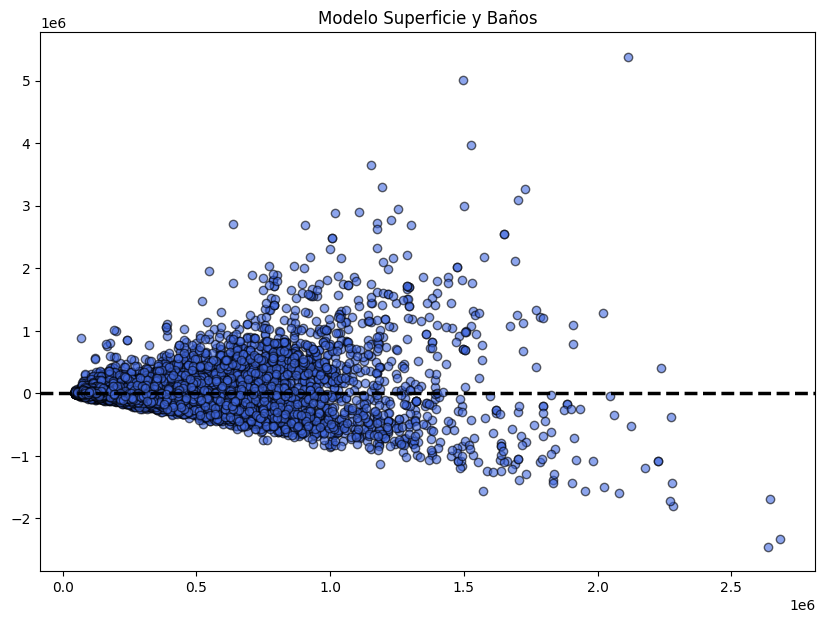

In [60]:
# Realizamos el gráfico
plt.figure(figsize=(10,7))
plt.scatter(x=y_train_sup_baños, y=residuos_sup_baños,
            alpha=0.6, c='royalblue', edgecolor='black')
plt.axhline(y=0, c='black', ls='--', linewidth=2.5)
plt.title("Modelo Superficie y Baños");

In [61]:
# Calculamos los residuos para el modelo de interacción
residuos_interaccion =  y_train - y_train_interaccion

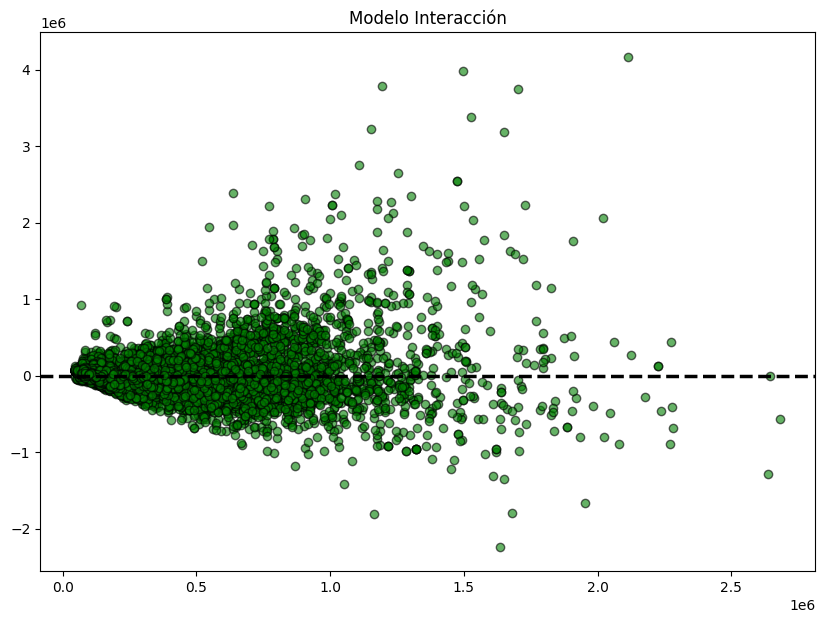

In [62]:
# Realizamos el gráfico
plt.figure(figsize=(10,7))
plt.scatter(x=y_train_sup_baños, y=residuos_interaccion,
            alpha=0.6, c='green', edgecolor='black')
plt.axhline(y=0, c='black', ls='--', linewidth=2.5)
plt.title("Modelo Interacción");